In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


#tell pandas to display wide tables as pretty HTML tables
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)

def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecesasry plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()

### Build an ETF for RUSSELL 1000 Index 


_How can we invest in the RUI Index?_  
One product that allows you to get the returns associated with an index is an exchange-traded funds (ETF). In this notebook we build an ETF that tracks RUI Index using the top 10 stocks of the index. We show how to do that for a particular day.


Russell 1000 (RUI) is an index that tracks 1000 companies. The way the index is calculated, as well as the list of companies and other details can be found online, e.g. https://en.wikipedia.org/wiki/Russell_Indexes#Construction_methodology. Russell 1000 Index is tracked by several exchange-traded funds (ETF), such as the iShares Russell 1000 Index (NYSE Arca: IWB) and the Vanguard Russell 1000 Index ETF (NASDAQ: VONE). 

__Next Steps__
 - In the future I plan to extend the method to rebalance the tracking more often. 
 - Automatically keep track of the top n companies in the index 
 - Do the same using Kalman Filters  
 - Allow for putting some weight on a cash account with a constant interest rate (model it as a stock with a deterministic return)
 
 
#### 1. Data 
Below we start by downloading the relevant data of the top 10 tickers and the index from Quandl, and more specifically from Yahoo's data source provided from Quandle. 

In [2]:
import Quandl
Index = 'INDEX_RUI'
Stocks = ['AAPL', 'XOM', 'MSFT', 'JNJ', "BA", 'GE', 'CVX', 'WFC', 'JPM', 'PG']
Tickers = [Index] + Stocks
symbols = []
for i in Tickers:
    symbols.append('YAHOO/' + str(i) + '.6')



We make a plot of the value of the index in blue,  and the top 3 tickers Apple, Exxon Mobile and Microsoft. 

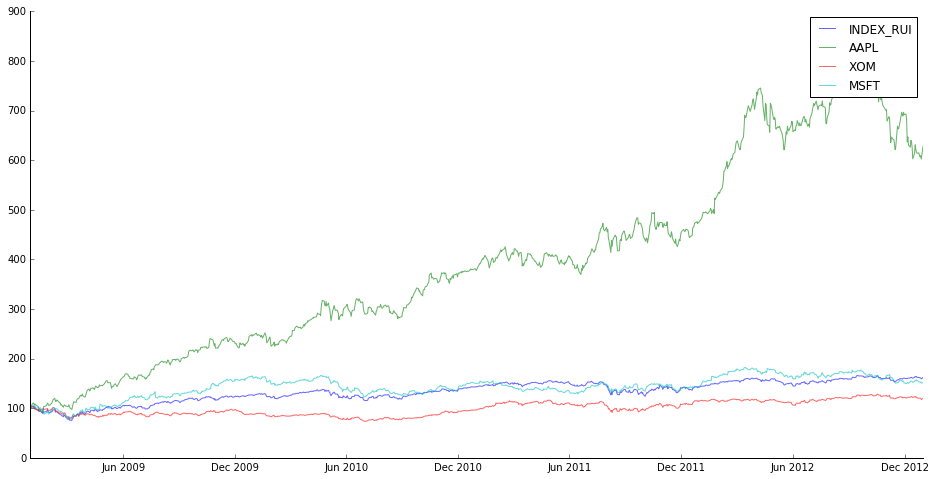

In [3]:
df_plot = Quandl.get(symbols, authtoken="cL17eWmFWnxfQk-soF_V",  trim_start="2008-12-31",
                trim_end="2012-12-31", collapse = 'daily',  transformation = 'normalize')
df_plot.columns = Tickers

plt.figure(figsize=(16, 8))
for col in df_plot.columns[:4]:
    plt.plot(df_plot.index.values, df_plot.loc[:,col], alpha=.6, label=col)
plt.legend()
remove_border()

#### 2. Method  
We will use the idea of regression. The target will be the daily returns of the index and the features will be the daily returns of the top 10 stocks.    

 - Why daily?
 - Why those times? 

In [4]:
StartDate = '2008-12-31'
EndDate = '2011-12-31'

Returns = Quandl.get(symbols, authtoken="cL17eWmFWnxfQk-soF_V", trim_start=StartDate, trim_end=EndDate, transformation="rdiff")
Returns.columns = Tickers
Returns.head()

,INDEX_RUI,AAPL,XOM,MSFT,JNJ,BA,GE,CVX,WFC,JPM,PG
Date,,,,,,,,,,,
2009-01-02,0.031511,0.063269,0.022673,0.045782,0.013705,0.060464,0.053704,0.034473,0.017639,0.006421,0.015852
2009-01-05,-0.003538,0.042204,-0.000123,0.009346,-0.009893,0.020331,-0.025776,0.001830,-0.064667,-0.066986,-0.007166
2009-01-06,0.009235,-0.016494,-0.016293,0.011696,-0.005995,0.003032,0.013830,0.009001,-0.018532,0.021538,-0.002887
2009-01-07,-0.030080,-0.021608,-0.025529,-0.060212,-0.009382,-0.033470,-0.044484,-0.043827,-0.060639,-0.059906,-0.017533
2009-01-08,0.004381,0.018569,0.010735,0.031266,-0.001860,0.000670,0.001862,0.003786,-0.005798,-0.030972,-0.010969


We could do a simple linear regression:

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split


X = Returns.iloc[:,1:]
y = Returns.iloc[:,0]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 4)

regr = LinearRegression()
regr.fit(x_train, y_train)
print "R2 score = ", regr.score(x_test, y_test)
print "The sum of the regression coefficients = ", np.sum(regr.coef_)


R2 score =  0.948535317896
The sum of the regression coefficients =  1.01232937709


But in reality we want to the coefficients of the regression to obey two rules:   
1. Sum to 1 (allocate all capital)
2. Be always positive (avoid shorting any stock)  

In this case, we need to solve a quadratic programming problem as follows.  
We assume that $y = X \beta + \epsilon$  
$$ min || y - \beta X||^2 $$
We expand out to get 
$$
\begin{align}
|| y - \beta X||^2 &=  \\
&= (y - X \beta)^T (y - X \beta) \\
&= (y^T - \beta^T  X^T ) (y - X \beta)  \\
&= y^T y  - y^T X \beta -  \beta^T X^T y - \beta^T X^T X \beta
&= y^T y  - 2 y^T X \beta - \beta^T X^T X \beta
\end{align}
$$

Hence our problem becomes:    

minimize $ \{ \frac{1}{2} \beta^{T} X^{T} X \beta - y^{T} X \beta \}$
subject to $\sum \beta_i =1$ and $\beta_i \geq 0$.

We use `cvxopt` package to solve the quadratic programming problem, using the function `solver.qp`. The format of the cvxopt problem solver is the following:   

minimize $ \{ \frac{1}{2} x^{T} P x + q^{T} x \}$
subject to $G x \leq h $ and $A x = b$.  
Hence we set 
$$
\begin{align}
x &= \beta \\
q &= - X^T y \\
P &= X^T X \\
G &= -I\\
h &= [0 \ldots 0]^T\\
A &= [1 \ldots 1]\\
b &= 1\\
\end{align}
$$
For details of the solver see http://cvxopt.org/userguide/coneprog.html#cvxopt.solvers.qp

In [14]:
def CLS(Y,X):
    Q = X.T*X
    c = -X.T*Y
    from cvxopt import matrix
    from cvxopt import solvers
    G = -np.eye(len(Q))
    h = np.zeros((len(Q),1))
    A = np.ones((1,len(Q)))
    b = np.ones((1,1))
    sol = solvers.qp(matrix(Q),matrix(c),matrix(G),matrix(h),matrix(A),matrix(b))
    betas = np.asarray(sol['x'])
    return betas

def SampleFit(Returns, sampleStart, sampleEnd):
    Sample = Returns[sampleStart:sampleEnd]
    Y = np.matrix(Sample["INDEX_RUI"]).T
    X = np.matrix(Sample.iloc[:,1:])
    betas = CLS(Y,X)
    return betas

In [15]:
SampleStart = '2011-04-30'
SampleEnd = '2011-07-31'
TestStart = '2011-08-01'
TestEnd = '2011-08-31'
y = Returns[TestStart:TestEnd]["INDEX_RUI"]
X = Returns[TestStart:TestEnd].iloc[:,1:]
betas = SampleFit(Returns, SampleStart, SampleEnd)
betasDict = dict(zip(Stocks,betas))
betasDict

     pcost       dcost       gap    pres   dres
 0: -2.3084e-03 -1.0027e+00  1e+00  1e-17  3e+00
 1: -2.3086e-03 -1.2692e-02  1e-02  5e-17  4e-02
 2: -2.3191e-03 -2.7514e-03  4e-04  8e-17  1e-03
 3: -2.3584e-03 -2.4166e-03  6e-05  7e-17  2e-18
 4: -2.3630e-03 -2.3669e-03  4e-06  5e-17  2e-18
 5: -2.3638e-03 -2.3641e-03  3e-07  1e-16  2e-18
 6: -2.3639e-03 -2.3639e-03  2e-08  8e-17  2e-18
Optimal solution found.


{'AAPL': array([ 0.06323705]),
 'BA': array([ 0.11576506]),
 'CVX': array([ 0.26659028]),
 'GE': array([ 0.14030833]),
 'JNJ': array([ 0.11131725]),
 'JPM': array([ 0.02095353]),
 'MSFT': array([ 0.12557569]),
 'PG': array([ 0.07799086]),
 'WFC': array([ 0.07581244]),
 'XOM': array([ 0.0024495])}

To do a reality check verify that $\beta_i \geq 0$ and also that  $\sum \beta_i =1$.


In [16]:
print betas.sum()

1.0


#### 4. Rebalancing
Now we get the weights for a particular day. At the end of that day our portofolio drifts away from the index. Over a period of time we expect error of our tracking method to grow. One way of addressing that is to rebalance the weights. One can theoretically rebalance the weights every night, but that might incure high trading costs. There is a subtler question: if we allocate capital 40-60 on two stocks today, due to the drift the allocation will be different tomorrow. Should we try to trade to bring it back to 40-60 or should we leave it and rebalance at the next checkpoint?


Below we see the effect of drift after the rebalancing over number of days, assuming the rebalancing happened at day 0. 

Date
2011-08-01    0.016057
2011-08-02   -0.019761
2011-08-03    0.009411
2011-08-04   -0.038719
2011-08-05   -0.009937
2011-08-08   -0.054628
2011-08-09    0.058888
2011-08-10   -0.027593
2011-08-11    0.027523
2011-08-12    0.008804
2011-08-15    0.017030
2011-08-16   -0.007642
2011-08-17   -0.000105
2011-08-18   -0.037825
2011-08-19   -0.027373
2011-08-22    0.001152
2011-08-23    0.048143
2011-08-24    0.006906
2011-08-25   -0.006539
2011-08-26    0.026383
2011-08-29    0.016659
2011-08-30    0.000051
2011-08-31   -0.013231
Name: AAPL, dtype: float64
Date
2011-08-01   -0.002381
2011-08-02   -0.022111
2011-08-03   -0.001542
2011-08-04   -0.049923
2011-08-05    0.013272
2011-08-08   -0.061882
2011-08-09    0.020658
2011-08-10   -0.044120
2011-08-11    0.052183
2011-08-12    0.005868
2011-08-15    0.031806
2011-08-16   -0.010634
2011-08-17    0.008980
2011-08-18   -0.043420
2011-08-19   -0.016070
2011-08-22    0.005444
2011-08-23    0.049587
2011-08-24   -0.001629
2011-08-25   -0.0240

0.077100930625695868

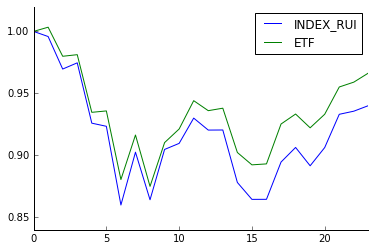

In [21]:
L = dict()
for ticker in Stocks:
    stock = X[ticker]
    print stock
    L[ticker] = betasDict[ticker].tolist()
    for r in stock:
        L[ticker].append(L[ticker][-1]*(1+r))  

df = pd.DataFrame(L)


temp = df.sum(axis=1)

r = np.asarray(temp[1:])/np.asarray(temp[:-1])-1

y_est = r
error = y-y_est
out = pd.DataFrame(y)
out["ETF"] = r
out


y_levels = [1]
ETF_levels =[1]
for r in y_est:
    ETF_levels.append(ETF_levels[-1]*(1+r))
for r in y:
    y_levels.append(y_levels[-1]*(1+r))

myDF = pd.DataFrame(y_levels,columns=["INDEX_RUI"])
myDF["ETF"] = ETF_levels

plt.figure(figsize=(16, 8))

myDF.plot()
remove_border()


TE = np.std(error)*np.sqrt(252)
TE